## Case 9 — Dự báo cảm cúm (Flu cases forecasting)

Mục tiêu:
- Train **mô hình 1 (không tối ưu)** để thấy hiện tượng **training loss giảm nhưng `val_loss` tăng** (overfitting).
- Sau đó thêm các kỹ thuật đề xuất (regularization + dropout + early stopping) và train **lần 2** để `val_loss` tốt hơn.
- Lưu lại mô hình sau khi train.

Dữ liệu: `flu_cases_vietnam.xls` (thực chất là CSV) gồm:
- `year`, `week`
- `cases` (số ca cảm cúm)
- `temperature`, `humidity`, `rainfall`


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from pathlib import Path
from IPython.display import display

# chạy được dù notebook đang mở ở root hay trong folder case9
BASE_DIR = Path.cwd()
if not (BASE_DIR / "flu_cases_vietnam.xls").exists():
    if (BASE_DIR / "case9-du-bao-cam-cum" / "flu_cases_vietnam.xls").exists():
        BASE_DIR = BASE_DIR / "case9-du-bao-cam-cum"

DATA_PATH = BASE_DIR / "flu_cases_vietnam.xls"  # file extension .xls nhưng nội dung là CSV
MODEL_OUT_1 = BASE_DIR / "flu_forecast_overfit.keras"
MODEL_OUT_2 = BASE_DIR / "flu_forecast_regularized.keras"

print("TensorFlow:", tf.__version__)
print("DATA_PATH:", DATA_PATH.resolve())

TensorFlow: 2.20.0
DATA_PATH: D:\Programming\PTHTTM\TieuLuanDeploy\case9-du-bao-cam-cum\flu_cases_vietnam.xls


Shape: (520, 6)
year             int64
week             int64
cases            int64
temperature    float64
humidity       float64
rainfall       float64
dtype: object


,year,week,cases,temperature,humidity,rainfall,date
0,2015,1,194,24.29,79.51,62.20,2014-12-29
1,2015,2,197,22.37,79.01,74.64,2015-01-05
2,2015,3,190,20.98,80.98,57.94,2015-01-12
3,2015,4,203,20.59,73.11,49.59,2015-01-19
4,2015,5,198,18.31,79.17,62.52,2015-01-26


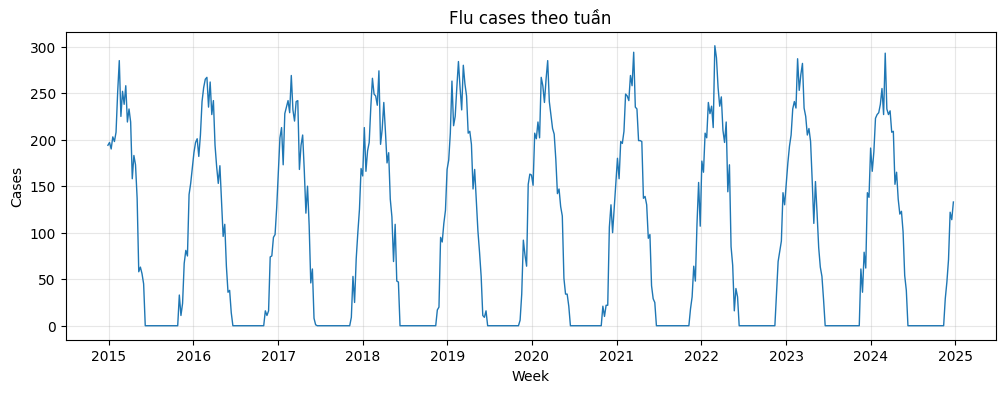

In [ ]:
# 1) Load dữ liệu
# Thử read_csv trước vì file thực chất là CSV

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print(df.dtypes)

df = df.sort_values(["year", "week"]).reset_index(drop=True)

# tạo cột date theo ISO week cho dễ vẽ
# ISO: %G = ISO year, %V = ISO week, %u = ISO weekday (1=Mon)
df["date"] = pd.to_datetime(
    df["year"].astype(str) + df["week"].astype(str).str.zfill(2) + "1",
    format="%G%V%u",
    errors="coerce",
)

display(df.head())

plt.figure(figsize=(12, 4))
plt.plot(df["date"], df["cases"], linewidth=1)
plt.title("Flu cases theo tuần")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 2) Biến time-series thành supervised learning
# Dự báo cases(t+1) dựa vào:
# - cases của N tuần trước: cases(t-N+1..t)
# - thời tiết tại tuần t: temperature(t), humidity(t), rainfall(t)

WINDOW = 8  # ưu tiên nhanh nhưng vẫn đủ để học xu hướng

cases = df["cases"].to_numpy(dtype=np.float32)
weather = df[["temperature", "humidity", "rainfall"]].to_numpy(dtype=np.float32)

X_list, y_list, date_list = [], [], []
for t in range(WINDOW - 1, len(df) - 1):
    past_cases = cases[t - WINDOW + 1 : t + 1]  # length = WINDOW
    x = np.concatenate([past_cases, weather[t]], axis=0)
    y = cases[t + 1]  # forecast next week
    X_list.append(x)
    y_list.append(y)
    date_list.append(df.loc[t + 1, "date"])  # ngày của target

X = np.stack(X_list)
y = np.array(y_list, dtype=np.float32)
dates_y = pd.to_datetime(date_list)

print("X shape:", X.shape, "y shape:", y.shape)

# split theo thời gian (không shuffle)
train_end = int(0.8 * len(X))
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:], y[train_end:]
dates_val = dates_y[train_end:]

print("Train:", X_train.shape, "Val:", X_val.shape)

# baseline metric: MAE nếu dự đoán y(t+1) = y(t)
naive_pred = X_val[:, WINDOW - 1]  # case tại tuần t
naive_mae = np.mean(np.abs(naive_pred - y_val))
print("Naive MAE:", float(naive_mae))

# --- subset nhỏ để demo overfitting cho Model 1 ---
# Với dataset này nếu train "đúng bài" thì val_loss có thể vẫn giảm.
# Để chắc chắn thấy overfit: chỉ dùng 1 phần nhỏ dữ liệu train để mô hình dễ memorize.
OVERFIT_TRAIN_FRAC = 0.25
n_small = max(32, int(len(X_train) * OVERFIT_TRAIN_FRAC))
X_train_small, y_train_small = X_train[:n_small], y_train[:n_small]
print("Overfit-demo train:", X_train_small.shape, "Val:", X_val.shape)

X shape: (512, 11) y shape: (512,)
Train: (409, 11) Val: (103, 11)
Naive MAE: 15.281553268432617
Overfit-demo train: (102, 11) Val: (103, 11)


In [ ]:
# 3) Mô hình 1 — Cố tình KHÔNG tối ưu để overfit
# Dấu hiệu mong muốn: loss(train) giảm nhưng val_loss tăng (sau vài epoch).
# Chiến lược: train trên tập train nhỏ (X_train_small) + mạng lớn.

tf.keras.utils.set_random_seed(42)

normalizer_1 = tf.keras.layers.Normalization()
normalizer_1.adapt(X_train_small)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_small.shape[1],)),
    normalizer_1,
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(1),
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"],
)

history_1 = model_1.fit(
    X_train_small,
    y_train_small,
    validation_data=(X_val, y_val),
    epochs=150,  # vẫn nhanh vì train set rất nhỏ
    batch_size=16,
    verbose=1,
)

print("Model 1 - final train loss/mae:", history_1.history["loss"][-1], history_1.history["mae"][-1])
print("Model 1 - final val   loss/mae:", history_1.history["val_loss"][-1], history_1.history["val_mae"][-1])

model_1.save(MODEL_OUT_1)
print("Saved:", MODEL_OUT_1.resolve())

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 15778.7607 - mae: 85.5152 - val_loss: 13487.7959 - val_mae: 82.5477
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8548.9150 - mae: 64.5349 - val_loss: 2466.6155 - val_mae: 40.2072
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3266.9175 - mae: 43.6311 - val_loss: 1198.9263 - val_mae: 24.3126
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1018.8397 - mae: 21.5020 - val_loss: 1117.6454 - val_mae: 23.2452
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 692.8727 - mae: 17.5576 - val_loss: 791.5806 - val_mae: 18.7328
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 815.2546 - mae: 17.7540 - val_loss: 422.1457 - val_mae: 13.0372
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 500.9007 - mae: 14.5587 - val_loss: 391.1114 - val_mae: 11.9633
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 385.3690 - mae: 12.1371 - val_loss: 381.4734 - val_mae: 12.3458
Epoch 9/150
7/

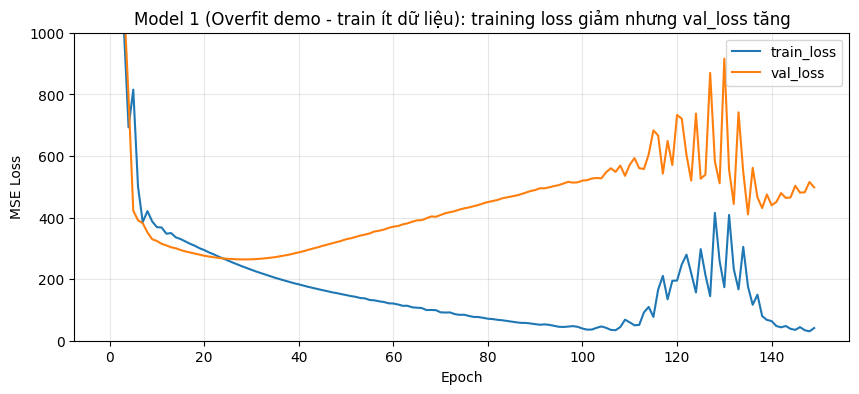

In [ ]:
# Vẽ biểu đồ loss/val_loss của mô hình 1

plt.figure(figsize=(10, 4))
plt.plot(history_1.history["loss"], label="train_loss")
plt.plot(history_1.history["val_loss"], label="val_loss")
plt.title("Model 1 (Overfit demo - train ít dữ liệu): training loss giảm nhưng val_loss tăng")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.ylim(0, 1000)
plt.legend()
plt.show()

In [ ]:
# 4) Mô hình 2 — Thêm "lớp"/kỹ thuật để giảm overfitting
# - L2 regularization
# - Dropout
# - EarlyStopping (restore best weights)

from tensorflow.keras import regularizers

tf.keras.utils.set_random_seed(42)

normalizer_2 = tf.keras.layers.Normalization()
normalizer_2.adapt(X_train)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    normalizer_2,

    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.30),

    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.20),

    tf.keras.layers.Dense(1),
])

model_2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=["mae"],
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5),
]

history_2 = model_2.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    callbacks=callbacks,
    verbose=1,
)

best_epoch = int(np.argmin(history_2.history["val_loss"]))
print("Model 2 - best epoch:", best_epoch)
print("Model 2 - best val_loss:", float(np.min(history_2.history["val_loss"])))

model_2.save(MODEL_OUT_2)
print("Saved:", MODEL_OUT_2.resolve())

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 17244.1309 - mae: 88.6913 - val_loss: 17549.2207 - val_mae: 90.9241 - learning_rate: 0.0010
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 16200.3438 - mae: 86.4042 - val_loss: 15716.9785 - val_mae: 86.8214 - learning_rate: 0.0010
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 13447.2656 - mae: 79.2299 - val_loss: 11365.5830 - val_mae: 74.8355 - learning_rate: 0.0010
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8414.7021 - mae: 62.8073 - val_loss: 5291.8594 - val_mae: 50.9164 - learning_rate: 0.0010
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3603.7571 - mae: 40.9295 - val_loss: 1958.2865 - val_mae: 31.1742 - learning_rate: 0.0010
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1849.6094 - mae: 30.4557 - val_loss: 1118.6162 - val_mae: 24.0817 - learning_rate: 0.0010
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1179.2798 - mae: 23.1763 - val_loss: 689

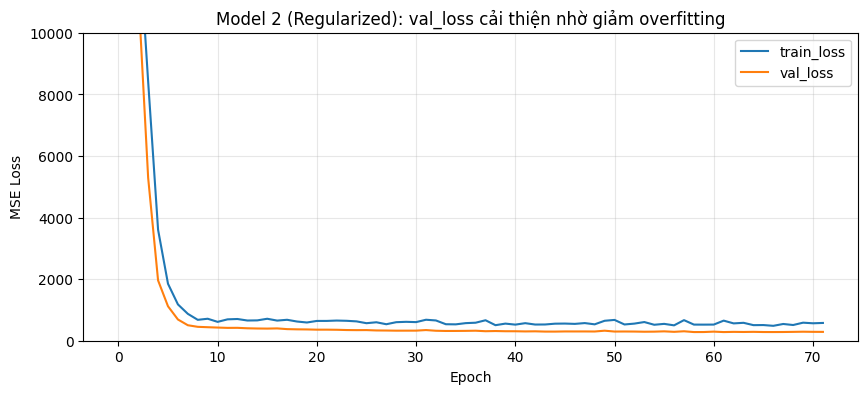

Naive MAE: 15.281553268432617
Model 1 val MAE: 14.389532089233398 val MSE: 497.8533020019531
Model 2 val MAE: 10.825460433959961 val MSE: 280.8034973144531


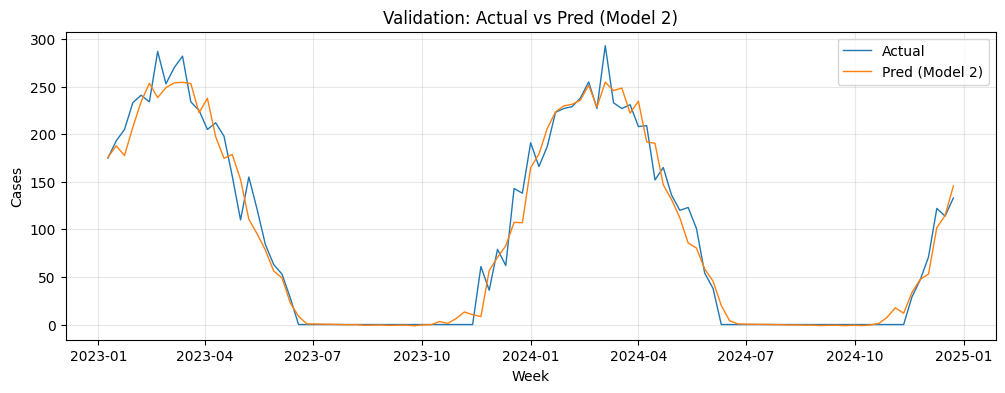

In [ ]:
# Vẽ biểu đồ loss/val_loss của mô hình 2 và so sánh nhanh

plt.figure(figsize=(10, 4))
plt.plot(history_2.history["loss"], label="train_loss")
plt.plot(history_2.history["val_loss"], label="val_loss")
plt.title("Model 2 (Regularized): val_loss cải thiện nhờ giảm overfitting")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.ylim(0, 10000)
plt.legend()
plt.show()

# Evaluate cuối cùng
val_loss_1, val_mae_1 = model_1.evaluate(X_val, y_val, verbose=0)
val_loss_2, val_mae_2 = model_2.evaluate(X_val, y_val, verbose=0)
print("Naive MAE:", float(naive_mae))
print("Model 1 val MAE:", float(val_mae_1), "val MSE:", float(val_loss_1))
print("Model 2 val MAE:", float(val_mae_2), "val MSE:", float(val_loss_2))

# Plot dự đoán trên tập validation (model 2)
pred_2 = model_2.predict(X_val, verbose=0).reshape(-1)
plt.figure(figsize=(12, 4))
plt.plot(dates_val, y_val, label="Actual", linewidth=1)
plt.plot(dates_val, pred_2, label="Pred (Model 2)", linewidth=1)
plt.title("Validation: Actual vs Pred (Model 2)")
plt.xlabel("Week")
plt.ylabel("Cases")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()